In [ ]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import tsaug
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

In [ ]:
df_diagnostics = pd.read_excel('Diagnostics.xlsx')
df_diagnostics.shape

(10646, 16)

In [ ]:
df_diagnostics.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


In [ ]:
df_diagnostics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10646 entries, 0 to 10645
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   FileName         10646 non-null  object
 1   Rhythm           10646 non-null  object
 2   Beat             10646 non-null  object
 3   PatientAge       10646 non-null  int64 
 4   Gender           10646 non-null  object
 5   VentricularRate  10646 non-null  int64 
 6   AtrialRate       10646 non-null  int64 
 7   QRSDuration      10646 non-null  int64 
 8   QTInterval       10646 non-null  int64 
 9   QTCorrected      10646 non-null  int64 
 10  RAxis            10646 non-null  int64 
 11  TAxis            10646 non-null  int64 
 12  QRSCount         10646 non-null  int64 
 13  QOnset           10646 non-null  int64 
 14  QOffset          10646 non-null  int64 
 15  TOffset          10646 non-null  int64 
dtypes: int64(12), object(4)
memory usage: 1.3+ MB


In [ ]:
df_diagnostics.isna().sum()

FileName           0
Rhythm             0
Beat               0
PatientAge         0
Gender             0
VentricularRate    0
AtrialRate         0
QRSDuration        0
QTInterval         0
QTCorrected        0
RAxis              0
TAxis              0
QRSCount           0
QOnset             0
QOffset            0
TOffset            0
dtype: int64

In [ ]:
df_diagnostics['Rhythm'].value_counts()

SB       3889
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: Rhythm, dtype: int64

## Exploratory Data Analysis

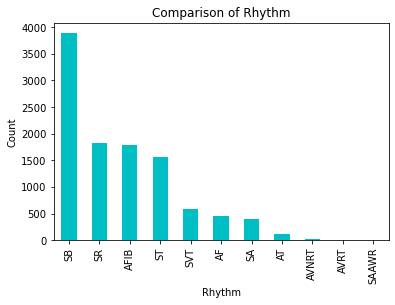

In [ ]:
df_diagnostics['Rhythm'].value_counts(dropna = False).plot.bar(color = '#00bfc4')
plt.title('Comparison of Rhythm')
plt.xlabel('Rhythm')
plt.ylabel('Count')
plt.show()

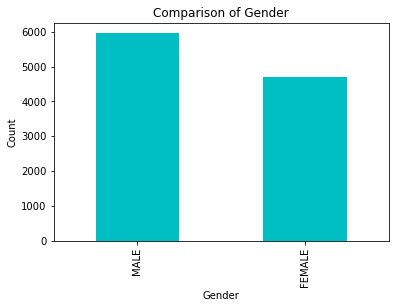

In [ ]:
df_diagnostics['Gender'].value_counts(dropna = False).plot.bar(color = '#00bfc4')
plt.title('Comparison of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [ ]:
totalagegroupcount = []
Rythoncat = ['SB','SR','AFIB','ST','SVT','AF','SA','AT','AVNRT','AVRT','ASSWR']
for cat in Rythoncat:
    df = df_diagnostics[df_diagnostics['Rhythm'] == cat]
    agebin_0_10 = 0
    agebin_10_20 = 0
    agebin_20_30 = 0
    agebin_30_40 = 0
    agebin_50_above = 0
    print(cat)
    for index, row in df.iterrows():
        if row['Rhythm'] == cat:
            if 0 < row['PatientAge'] <= 10:
                    agebin_0_10 += 1
            if 10 < row['PatientAge'] <= 20:
                agebin_10_20 += 1
            if 20 <= row['PatientAge'] <= 30:
                agebin_20_30 += 1
            if 40 <= row['PatientAge'] <= 50:
                agebin_30_40 += 1
            else:
                agebin_50_above += 1
    totalagegroupcount.append([agebin_0_10,agebin_10_20,agebin_20_30,agebin_30_40,agebin_50_above])

print(totalagegroupcount)

SB
SR
AFIB
ST
SVT
AF
SA
AT
AVNRT
AVRT
ASSWR
[[2, 38, 145, 619, 3270], [4, 32, 147, 345, 1481], [0, 0, 2, 57, 1723], [54, 63, 153, 221, 1347], [2, 13, 53, 121, 466], [0, 0, 3, 31, 414], [70, 73, 71, 44, 355], [4, 2, 5, 5, 116], [0, 0, 2, 0, 16], [0, 0, 1, 2, 6], [0, 0, 0, 0, 0]]


### Data Cleaning

In [ ]:
df_diagnostics = df_diagnostics.dropna() #drop null values
df_diagnostics = df_diagnostics.drop_duplicates(subset=['FileName']) # drop duplicates
df_diagnostics = df_diagnostics.drop(['Beat'], axis=1) # Dropping unwanted 'Beat' col
df_diagnostics = df_diagnostics.reset_index(drop = True) # reset index
df_diagnostics.shape

(10646, 15)

### Data Balancing

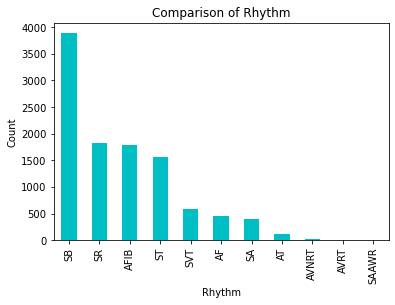

In [ ]:
df_diagnostics['Rhythm'].value_counts(dropna = False).plot.bar(color = '#00bfc4')
plt.title('Comparison of Rhythm')
plt.xlabel('Rhythm')
plt.ylabel('Count')
plt.show()

In [ ]:
sampletimes = 100

SBcount,SRcount,AFIBcount,STcount,SVTcount,AFcount,SAcount,ATcount,AVNRTcount,AVRTcount,SAAWRcount  = df_diagnostics['Rhythm'].value_counts()

df_SB = df_diagnostics[df_diagnostics['Rhythm'] == "SB"]
df_SR = df_diagnostics[df_diagnostics['Rhythm'] == "SR"]
df_AFIB = df_diagnostics[df_diagnostics['Rhythm'] == "AFIB"]
df_ST = df_diagnostics[df_diagnostics['Rhythm'] == "ST"]
df_SVT = df_diagnostics[df_diagnostics['Rhythm'] == "SVT"]
df_AF = df_diagnostics[df_diagnostics['Rhythm'] == "AF"]
df_SA = df_diagnostics[df_diagnostics['Rhythm'] == "SA"]
df_AT = df_diagnostics[df_diagnostics['Rhythm'] == "AT"]
df_AVNRT = df_diagnostics[df_diagnostics['Rhythm'] == "AVNRT"]
df_AVRT = df_diagnostics[df_diagnostics['Rhythm'] == "AVRT"]
df_SAAWR = df_diagnostics[df_diagnostics['Rhythm'] == "SAAWR"]

df_SB_under = df_SB.sample(sampletimes, replace=True)
df_SR_under = df_SR.sample(sampletimes, replace=True)
df_AFIB_under = df_AFIB.sample(sampletimes, replace=True)
df_ST_under = df_ST.sample(sampletimes, replace=True)
df_SVT_under = df_SVT.sample(sampletimes, replace=True)
df_AF_under = df_AF.sample(sampletimes, replace=True)
df_SA_under = df_SA.sample(sampletimes, replace=True)
df_AT_under = df_AT.sample(sampletimes, replace=True)
df_AVNRT_under = df_AVNRT.sample(sampletimes, replace=True)
df_AVRT_under = df_AVRT.sample(sampletimes, replace=True)
df_SAAWR_under = df_SAAWR.sample(sampletimes, replace=True)


df_diagnostics = pd.concat([df_SB_under, df_SR_under, df_AFIB_under, df_ST_under, df_SVT_under, df_AF_under, df_SA_under], axis=0)
df_diagnostics = df_diagnostics.sample(frac = 1)
df_diagnostics = df_diagnostics.reset_index(drop = True)
df_diagnostics

,FileName,Rhythm,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180118_173613_78000,SB,24,MALE,57,57,102,438,426,74,61,10,217,268,436
1,MUSE_20180118_135031_39000,ST,21,FEMALE,101,101,68,338,438,79,52,16,227,261,396
2,MUSE_20180116_182218_74000,AF,45,FEMALE,107,107,86,352,469,-5,243,18,223,266,399
3,MUSE_20180712_153447_70000,AF,69,FEMALE,157,163,72,302,488,-14,26,25,216,252,367
4,MUSE_20180116_133206_14000,SA,35,FEMALE,81,81,82,370,429,83,57,13,227,268,412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,MUSE_20180712_153529_20000,AF,70,FEMALE,138,133,88,362,548,20,177,23,213,257,394
696,MUSE_20180114_115203_43000,ST,74,FEMALE,119,119,80,360,506,-39,69,20,216,256,396
697,MUSE_20180209_172925_54000,SR,81,FEMALE,67,67,90,402,424,44,12,11,227,272,428
698,MUSE_20180210_122012_66000,SR,68,MALE,75,75,88,386,431,-24,50,12,209,253,402


In [ ]:
df_diagnostics['Rhythm'].value_counts()

SR      100
SA      100
ST      100
SB      100
SVT     100
AF      100
AFIB    100
Name: Rhythm, dtype: int64

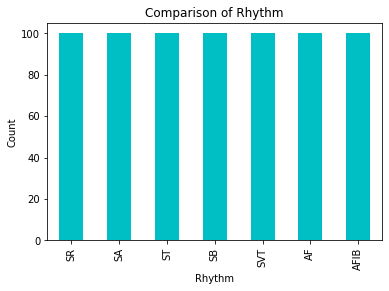

In [ ]:
df_diagnostics['Rhythm'].value_counts(dropna = False).plot.bar(color = '#00bfc4')
plt.title('Comparison of Rhythm')
plt.xlabel('Rhythm')
plt.ylabel('Count')
plt.show()

### Hot Encoding

In [ ]:
df_diagnostics.Rhythm = pd.Categorical(df_diagnostics.Rhythm)
df_diagnostics['Rhythm'] = df_diagnostics.Rhythm.cat.codes

df_diagnostics.Gender = pd.Categorical(df_diagnostics.Gender)
df_diagnostics['Gender'] = df_diagnostics.Gender.cat.codes

df_diagnostics

,FileName,Rhythm,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180118_173613_78000,3,24,1,57,57,102,438,426,74,61,10,217,268,436
1,MUSE_20180118_135031_39000,5,21,0,101,101,68,338,438,79,52,16,227,261,396
2,MUSE_20180116_182218_74000,0,45,0,107,107,86,352,469,-5,243,18,223,266,399
3,MUSE_20180712_153447_70000,0,69,0,157,163,72,302,488,-14,26,25,216,252,367
4,MUSE_20180116_133206_14000,2,35,0,81,81,82,370,429,83,57,13,227,268,412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,MUSE_20180712_153529_20000,0,70,0,138,133,88,362,548,20,177,23,213,257,394
696,MUSE_20180114_115203_43000,5,74,0,119,119,80,360,506,-39,69,20,216,256,396
697,MUSE_20180209_172925_54000,4,81,0,67,67,90,402,424,44,12,11,227,272,428
698,MUSE_20180210_122012_66000,4,68,1,75,75,88,386,431,-24,50,12,209,253,402


In [ ]:
X = df_diagnostics.drop(['FileName','Rhythm'], axis=1)
y = df_diagnostics["Rhythm"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [ ]:
classifier = svm.SVC()
classifier.fit(X, y)

SVC()

In [ ]:
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("confusion_matrix: \n", cm)

y_preds = classifier.predict(X_test)
y_preds = np.round(y_preds)
print("\n\n Classification Report: \n", classification_report(y_test, y_preds))

confusion_matrix: 
 [[ 5  3  0  1  1  3  5]
 [ 6  6  0  4  2  3  3]
 [ 0  0 14  3  2  2  0]
 [ 0  0  1 12  0  0  0]
 [ 0  0  8  3 11  2  0]
 [ 0  0  0  0  0 18  1]
 [ 0  0  0  0  0  1 20]]


 Classification Report: 
               precision    recall  f1-score   support

           0       0.45      0.28      0.34        18
           1       0.67      0.25      0.36        24
           2       0.61      0.67      0.64        21
           3       0.52      0.92      0.67        13
           4       0.69      0.46      0.55        24
           5       0.62      0.95      0.75        19
           6       0.69      0.95      0.80        21

    accuracy                           0.61       140
   macro avg       0.61      0.64      0.59       140
weighted avg       0.62      0.61      0.58       140



In [ ]:
print("Actual:     ",y_test[10:20].values)
print("Predicted: ",classifier.predict(X_test[10:20]))

Actual:      [3 6 1 4 0 1 6 4 4 4]
Predicted:  [3 6 0 4 1 3 6 2 3 2]


## Single Subject Demo

In [ ]:
zf = zipfile.ZipFile('ECGData.zip')
ecg12 = pd.read_csv(zf.open('ECGData/MUSE_20180210_120005_91000.csv'))
ecg12.head()

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,-43.92,-39.04,4.88,43.92,-24.40,-19.52,-14.64,-4.88,-58.56,-9.76,-117.12,-9.76
1,-48.80,-48.80,0.00,48.80,-24.40,-24.40,-9.76,4.88,-82.96,4.88,-126.88,-53.68
2,-68.32,-58.56,9.76,63.44,-39.04,-24.40,-14.64,19.52,-92.72,0.00,-136.64,-68.32
3,-73.20,-73.20,0.00,73.20,-39.04,-39.04,-14.64,29.28,-73.20,-4.88,-126.88,-48.80
4,-48.80,-43.92,4.88,48.80,-29.28,-19.52,-9.76,48.80,-19.52,19.52,-78.08,-87.84


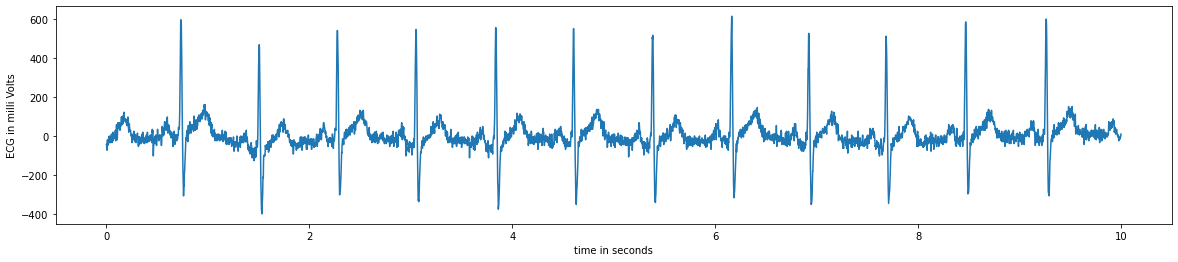

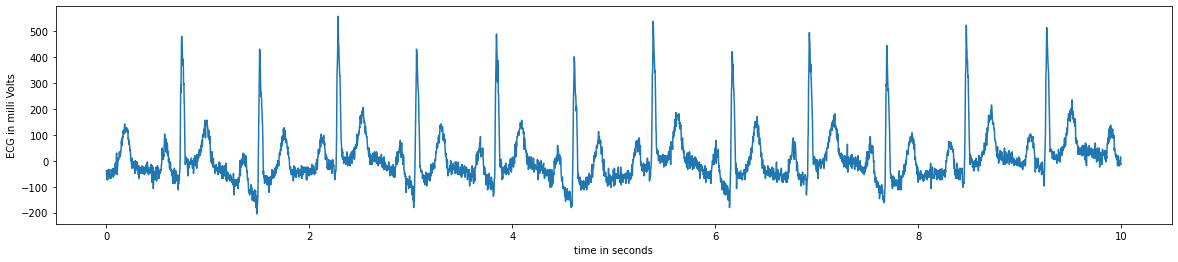

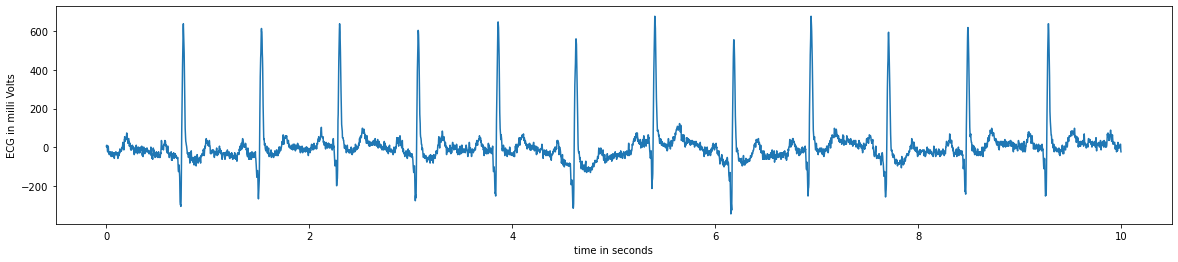

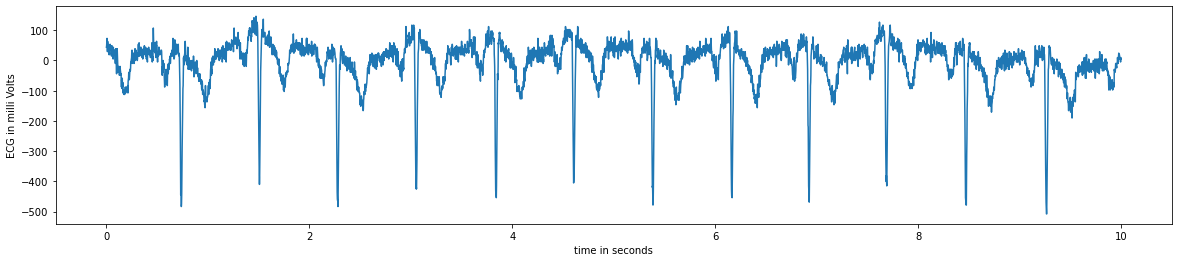

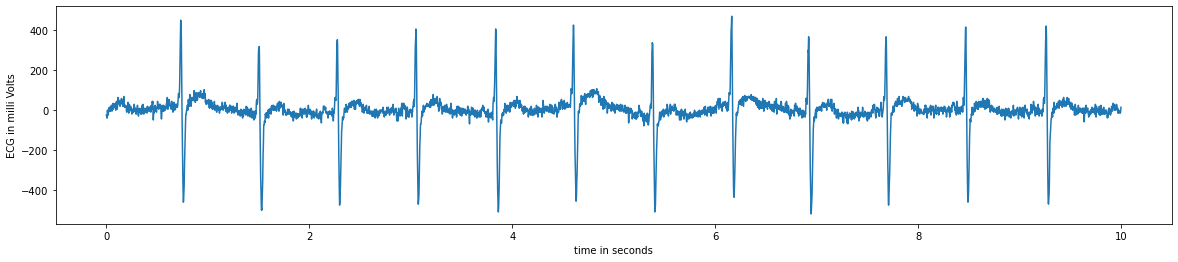

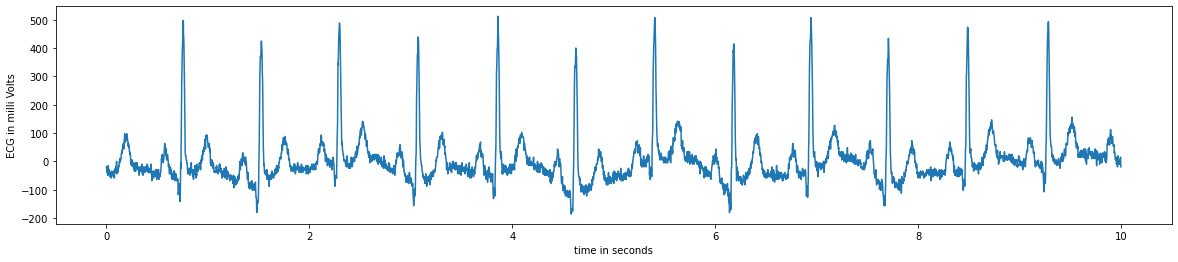

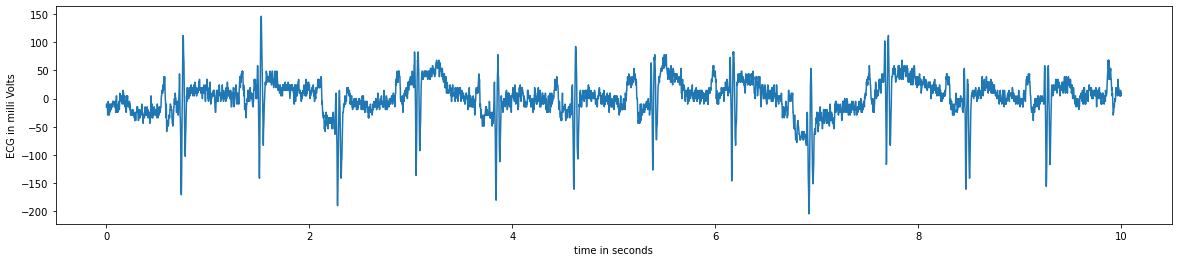

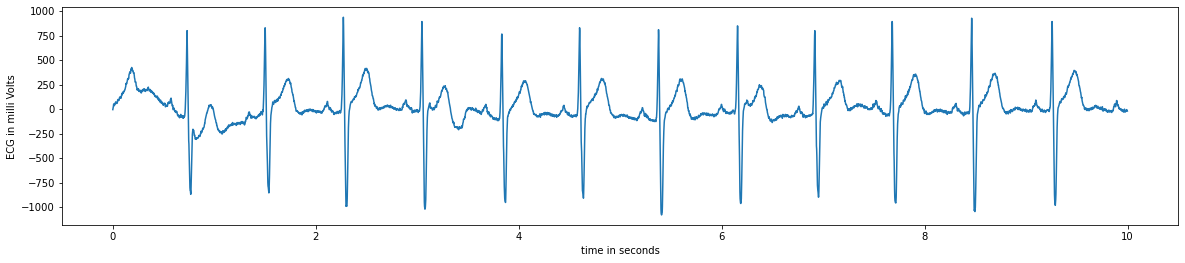

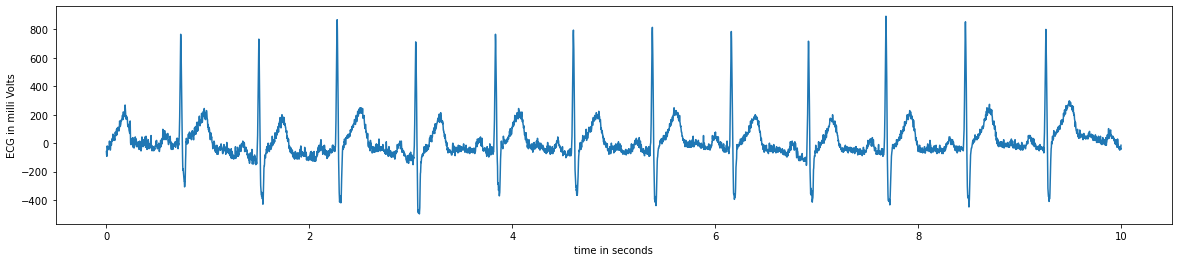

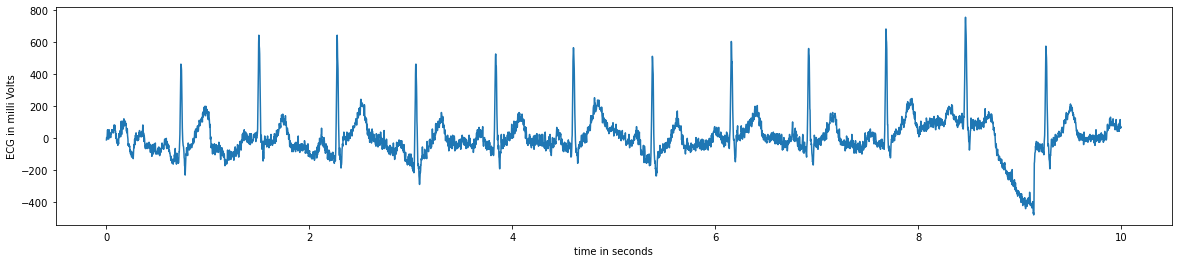

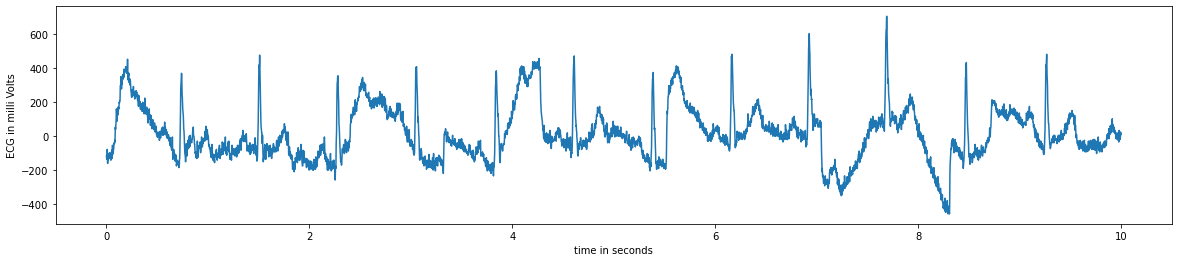

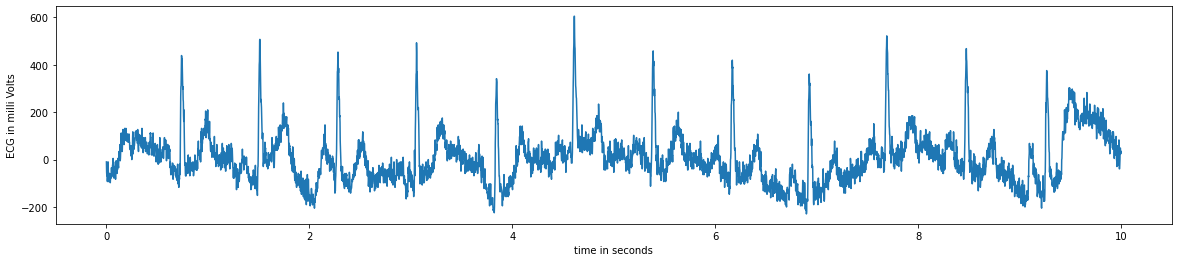

In [ ]:
for col in ecg12.columns:
    frequency = 500
    time_data = np.arange(ecg12[col].size) / frequency

    fig = plt.figure(figsize = (20, 4))
    plt.plot(time_data, ecg12[col])
    plt.xlabel("time in seconds")
    plt.ylabel("ECG in milli Volts")
    # plt.xlim(9, 10.2)
    # plt.ylim(-1, 1.5)
    # plt.title()
    plt.show()


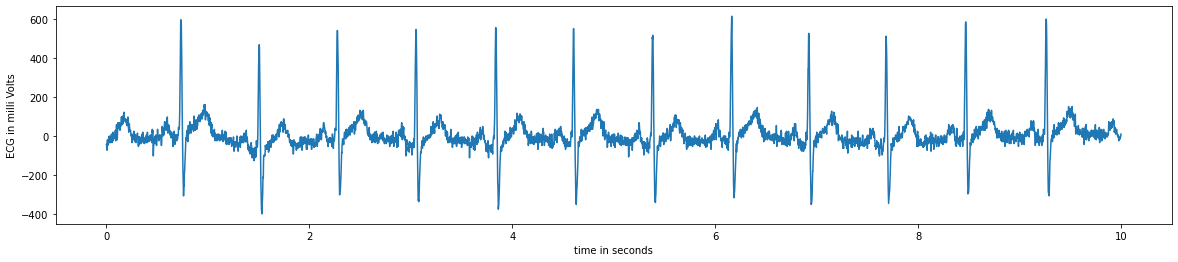

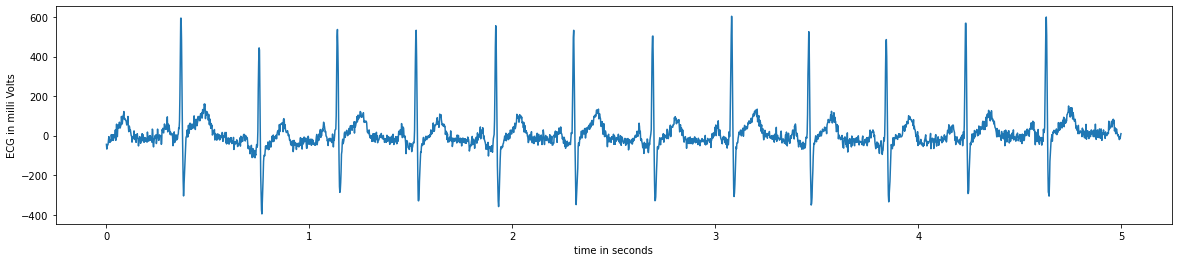

In [ ]:
data = ecg12['I']
frequency = 500

time_data = np.arange(data.size) / frequency
fig = plt.figure(figsize = (20, 4))
plt.plot(time_data, data.values)
plt.xlabel("time in seconds")
plt.ylabel("ECG in milli Volts")
plt.show()

X_aug_resize , Y_aug_resize = tsaug.Resize(size=2500).augment(time_data, data.values)
X_aug, Y_aug = tsaug.AddNoise(scale=0.1).augment(X_aug_resize, Y_aug_resize)


time_data = np.arange(Y_aug.size) / frequency
fig = plt.figure(figsize = (20, 4))
plt.plot(time_data, Y_aug)
plt.xlabel("time in seconds")
plt.ylabel("ECG in milli Volts")
plt.show()

## Multi Subjects

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, AveragePooling1D, Conv1DTranspose, MaxPooling1D, Flatten, Dropout

C:\Users\ganesh\anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (2.0.3)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [ ]:
I = []
II = []
III = []
aVL = []
aVR = []
aVF = []
V1 = []
V2 = []
V3 = []
V4 = []
V5 = []
V6 = []
for filename in df_diagnostics["FileName"]:
    ecg12 = pd.read_csv(zf.open('ECGData/'+filename+'.csv'))
    for lead in ecg12.columns:
        data = ecg12[lead]
        time_data = np.arange(data.size) / frequency
        X_aug_resize , Y_aug_resize = tsaug.Resize(size=2500).augment(time_data, data.values)
        X_aug, Y_aug = tsaug.AddNoise(scale=0.5).augment(X_aug_resize, Y_aug_resize)
        if lead == "I":
            I.append(np.transpose([Y_aug]))
        elif lead == "II":
            II.append(np.transpose([Y_aug]))
        elif lead == "III":
            III.append(np.transpose([Y_aug]))
        elif lead == "aVF":
            aVF.append(np.transpose([Y_aug]))
        elif lead == "aVL":
            aVL.append(np.transpose([Y_aug]))
        elif lead == "aVR":
            aVR.append(np.transpose([Y_aug]))
        elif lead == "V1":
            V1.append(np.transpose([Y_aug]))
        elif lead == "V2":
            V2.append(np.transpose([Y_aug]))
        elif lead == "V3":
            V3.append(np.transpose([Y_aug]))
        elif lead == "V4":
            V4.append(np.transpose([Y_aug]))
        elif lead == "V5":
            V5.append(np.transpose([Y_aug]))
        elif lead == "V6":
            V6.append(np.transpose([Y_aug]))

y = np.array(df_diagnostics["Rhythm"])

I = np.array(I,dtype='float32')
II = np.array(II,dtype='float32')
III = np.array(III,dtype='float32')
aVF = np.array(aVF,dtype='float32')
aVR = np.array(aVR,dtype='float32')
aVL = np.array(aVL,dtype='float32')
V1 = np.array(V1,dtype='float32')
V2 = np.array(V2,dtype='float32')
V3 = np.array(V3,dtype='float32')
V4 = np.array(V4,dtype='float32')
V5 = np.array(V5,dtype='float32')
V6 = np.array(V6,dtype='float32')

In [ ]:
print(I.shape,y.shape)
print(II.shape,y.shape)
print(III.shape,y.shape)
print(aVF.shape,y.shape)
print(aVL.shape,y.shape)
print(aVR.shape,y.shape)
print(V1.shape,y.shape)
print(V2.shape,y.shape)
print(V3.shape,y.shape)
print(V4.shape,y.shape)
print(V5.shape,y.shape)
print(V6.shape,y.shape)

(700, 2500, 1) (700,)
(700, 2500, 1) (700,)
(700, 2500, 1) (700,)
(700, 2500, 1) (700,)
(700, 2500, 1) (700,)
(700, 2500, 1) (700,)
(700, 2500, 1) (700,)
(700, 2500, 1) (700,)
(700, 2500, 1) (700,)
(700, 2500, 1) (700,)
(700, 2500, 1) (700,)
(700, 2500, 1) (700,)


In [ ]:
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
    model.add(MaxPooling1D(pool_size=10))
    model.add(Conv1D(filters=256, kernel_size=10, activation='relu'))
    model.add(MaxPooling1D(pool_size=15))
    model.add(LSTM(1024, activation='tanh', return_sequences=True))
    model.add(LSTM(1024, activation='tanh', return_sequences=True))
    model.add(LSTM(512, activation='tanh', return_sequences=True))
    model.add(LSTM(256, activation='tanh'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    return model

## Deep learning model for ECG LEAD I

Epoch 1/25
18/18 [==============================] - 57s 1s/step - loss: 1.8706 - accuracy: 0.2214 - val_loss: 1.6865 - val_accuracy: 0.2429
Epoch 2/25
18/18 [==============================] - 16s 898ms/step - loss: 1.5018 - accuracy: 0.3500 - val_loss: 1.4890 - val_accuracy: 0.3071
Epoch 3/25
18/18 [==============================] - 16s 910ms/step - loss: 1.4231 - accuracy: 0.3911 - val_loss: 1.6967 - val_accuracy: 0.2286
Epoch 4/25
18/18 [==============================] - 16s 871ms/step - loss: 1.2984 - accuracy: 0.4571 - val_loss: 1.4276 - val_accuracy: 0.4429
Epoch 5/25
18/18 [==============================] - 15s 846ms/step - loss: 1.1497 - accuracy: 0.5000 - val_loss: 1.3595 - val_accuracy: 0.4643
Epoch 6/25
18/18 [==============================] - 15s 839ms/step - loss: 1.1899 - accuracy: 0.5107 - val_loss: 1.3732 - val_accuracy: 0.4571
Epoch 7/25
18/18 [==============================] - 15s 850ms/step - loss: 1.1592 - accuracy: 0.5268 - val_loss: 1.1617 - val_accuracy: 0.4857
Ep

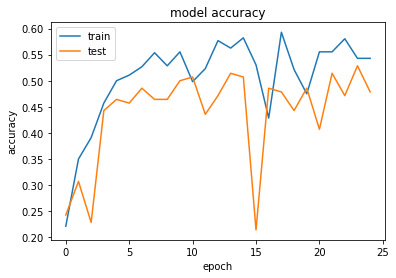

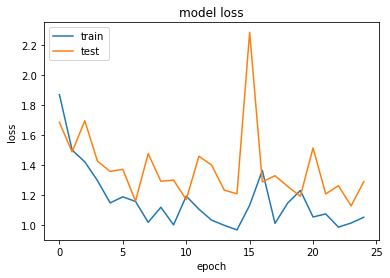

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(I, y, test_size = 0.20, random_state = 0)

lead_I_model = model()

history = lead_I_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

score = lead_I_model.evaluate(X_test, y_test)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Deep learning model for ECG LEAD II

Epoch 1/25
18/18 [==============================] - 57s 1s/step - loss: 1.9038 - accuracy: 0.2179 - val_loss: 1.6759 - val_accuracy: 0.2429
Epoch 2/25
18/18 [==============================] - 17s 945ms/step - loss: 1.6990 - accuracy: 0.2696 - val_loss: 1.6190 - val_accuracy: 0.2214
Epoch 3/25
18/18 [==============================] - 17s 975ms/step - loss: 1.4343 - accuracy: 0.3357 - val_loss: 1.5051 - val_accuracy: 0.2857
Epoch 4/25
18/18 [==============================] - 16s 912ms/step - loss: 1.3226 - accuracy: 0.4375 - val_loss: 1.3518 - val_accuracy: 0.5143
Epoch 5/25
18/18 [==============================] - 17s 934ms/step - loss: 1.5330 - accuracy: 0.3661 - val_loss: 1.5195 - val_accuracy: 0.3000
Epoch 6/25
18/18 [==============================] - 17s 955ms/step - loss: 1.4523 - accuracy: 0.3250 - val_loss: 1.4380 - val_accuracy: 0.4214
Epoch 7/25
18/18 [==============================] - 17s 971ms/step - loss: 1.3321 - accuracy: 0.4143 - val_loss: 1.6907 - val_accuracy: 0.2143
Ep

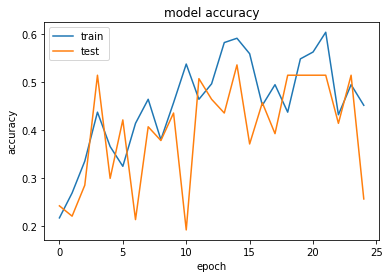

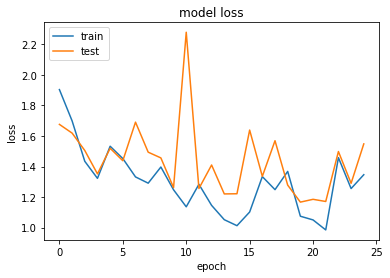

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(II, y, test_size = 0.20, random_state = 0)

lead_II_model = model()

history = lead_II_model.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_test, y_test))

score = lead_II_model.evaluate(X_test, y_test)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Deep learning model for ECG LEAD III

Epoch 1/25
18/18 [==============================] - 56s 1s/step - loss: 1.8794 - accuracy: 0.2143 - val_loss: 1.8137 - val_accuracy: 0.1500
Epoch 2/25
18/18 [==============================] - 17s 965ms/step - loss: 1.5706 - accuracy: 0.3071 - val_loss: 1.5472 - val_accuracy: 0.3071
Epoch 3/25
18/18 [==============================] - 17s 955ms/step - loss: 1.3897 - accuracy: 0.3554 - val_loss: 1.3285 - val_accuracy: 0.4071
Epoch 4/25
18/18 [==============================] - 17s 957ms/step - loss: 1.3661 - accuracy: 0.3857 - val_loss: 1.4935 - val_accuracy: 0.2857
Epoch 5/25
18/18 [==============================] - 17s 953ms/step - loss: 1.2273 - accuracy: 0.4232 - val_loss: 1.5344 - val_accuracy: 0.4000
Epoch 6/25
18/18 [==============================] - 16s 882ms/step - loss: 1.2256 - accuracy: 0.4089 - val_loss: 1.4676 - val_accuracy: 0.2714
Epoch 7/25
18/18 [==============================] - 17s 929ms/step - loss: 1.1810 - accuracy: 0.4661 - val_loss: 1.3964 - val_accuracy: 0.4286
Ep

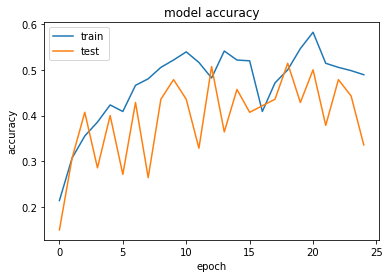

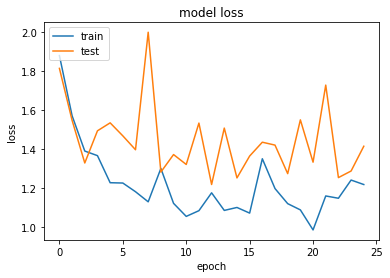

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(III, y, test_size = 0.20, random_state = 0)

lead_III_model = model()

history = lead_III_model.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_test, y_test))

score = lead_III_model.evaluate(X_test, y_test)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Deep learning model for ECG LEAD aVF

Epoch 1/25
18/18 [==============================] - 53s 1s/step - loss: 1.8493 - accuracy: 0.2196 - val_loss: 2.0474 - val_accuracy: 0.1643
Epoch 2/25
18/18 [==============================] - 13s 725ms/step - loss: 1.5081 - accuracy: 0.3554 - val_loss: 1.5266 - val_accuracy: 0.3500
Epoch 3/25
18/18 [==============================] - 13s 716ms/step - loss: 1.3778 - accuracy: 0.3625 - val_loss: 1.3943 - val_accuracy: 0.3857
Epoch 4/25
18/18 [==============================] - 13s 714ms/step - loss: 1.1906 - accuracy: 0.4643 - val_loss: 1.3455 - val_accuracy: 0.4714
Epoch 5/25
18/18 [==============================] - 13s 720ms/step - loss: 1.1477 - accuracy: 0.5393 - val_loss: 1.2877 - val_accuracy: 0.5357
Epoch 6/25
18/18 [==============================] - 13s 725ms/step - loss: 1.1157 - accuracy: 0.5232 - val_loss: 1.3096 - val_accuracy: 0.4500
Epoch 7/25
18/18 [==============================] - 13s 738ms/step - loss: 1.0661 - accuracy: 0.5286 - val_loss: 1.4054 - val_accuracy: 0.3786
Ep

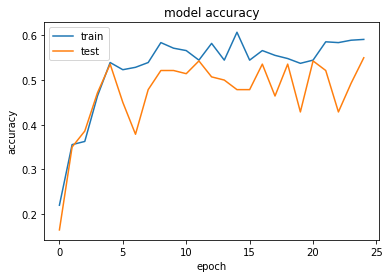

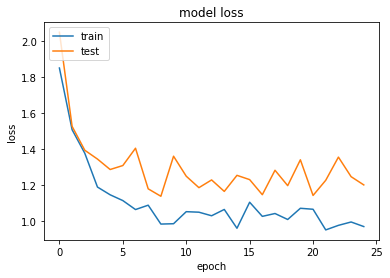

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(aVF, y, test_size = 0.20, random_state = 0)

aVF_model = model()

history = aVF_model.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_test, y_test))

score = aVF_model.evaluate(X_test, y_test)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Deep learning model for ECG LEAD aVR

Epoch 1/25
18/18 [==============================] - 48s 781ms/step - loss: 1.8114 - accuracy: 0.2589 - val_loss: 1.8422 - val_accuracy: 0.2500
Epoch 2/25
18/18 [==============================] - 9s 506ms/step - loss: 1.4780 - accuracy: 0.3268 - val_loss: 1.6329 - val_accuracy: 0.2643
Epoch 3/25
18/18 [==============================] - 9s 510ms/step - loss: 1.2849 - accuracy: 0.4179 - val_loss: 1.3412 - val_accuracy: 0.4143
Epoch 4/25
18/18 [==============================] - 9s 509ms/step - loss: 1.2527 - accuracy: 0.4500 - val_loss: 1.3821 - val_accuracy: 0.4714
Epoch 5/25
18/18 [==============================] - 9s 501ms/step - loss: 1.1884 - accuracy: 0.4679 - val_loss: 1.3968 - val_accuracy: 0.3857
Epoch 6/25
18/18 [==============================] - 9s 509ms/step - loss: 1.1083 - accuracy: 0.4893 - val_loss: 1.4497 - val_accuracy: 0.3857
Epoch 7/25
18/18 [==============================] - 9s 513ms/step - loss: 1.2555 - accuracy: 0.4482 - val_loss: 1.3830 - val_accuracy: 0.4000
Epoch

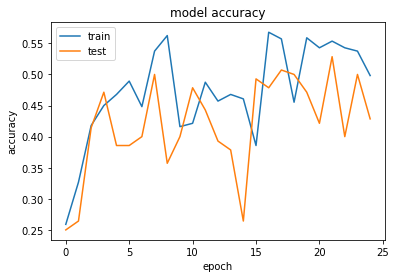

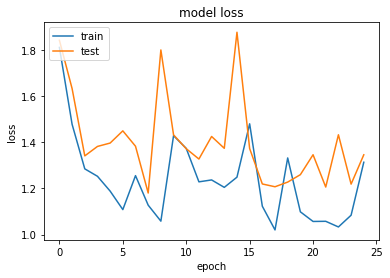

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(aVR, y, test_size = 0.20, random_state = 0)

aVR_model = model()

history = aVR_model.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_test, y_test))

score = aVR_model.evaluate(X_test, y_test)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Deep learning model for ECG LEAD aVL

Epoch 1/25
18/18 [==============================] - 48s 754ms/step - loss: 1.9266 - accuracy: 0.1821 - val_loss: 1.8120 - val_accuracy: 0.2286
Epoch 2/25
18/18 [==============================] - 8s 448ms/step - loss: 1.5956 - accuracy: 0.3071 - val_loss: 1.4599 - val_accuracy: 0.3571
Epoch 3/25
18/18 [==============================] - 8s 446ms/step - loss: 1.3407 - accuracy: 0.3929 - val_loss: 1.3727 - val_accuracy: 0.3786
Epoch 4/25
18/18 [==============================] - 8s 444ms/step - loss: 1.2770 - accuracy: 0.4500 - val_loss: 1.3272 - val_accuracy: 0.4714
Epoch 5/25
18/18 [==============================] - 8s 456ms/step - loss: 1.2199 - accuracy: 0.4625 - val_loss: 1.3112 - val_accuracy: 0.3857
Epoch 6/25
18/18 [==============================] - 8s 453ms/step - loss: 1.2373 - accuracy: 0.4750 - val_loss: 1.3767 - val_accuracy: 0.4071
Epoch 7/25
18/18 [==============================] - 8s 461ms/step - loss: 1.0888 - accuracy: 0.5411 - val_loss: 1.3084 - val_accuracy: 0.4643
Epoch

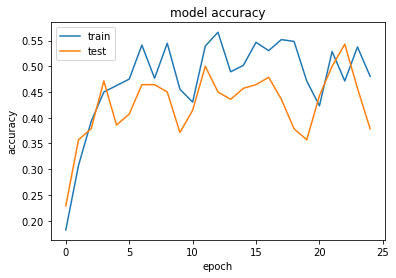

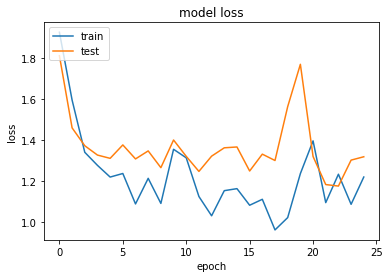

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(aVL, y, test_size = 0.20, random_state = 0)

aVL_model = model()

history = aVL_model.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_test, y_test))

score = aVL_model.evaluate(X_test, y_test)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Deep learning model for ECG LEAD V1

Epoch 1/25
18/18 [==============================] - 46s 674ms/step - loss: 1.8068 - accuracy: 0.2286 - val_loss: 1.7171 - val_accuracy: 0.2286
Epoch 2/25
18/18 [==============================] - 8s 424ms/step - loss: 1.5060 - accuracy: 0.3304 - val_loss: 1.5660 - val_accuracy: 0.2857
Epoch 3/25
18/18 [==============================] - 8s 422ms/step - loss: 1.2664 - accuracy: 0.4214 - val_loss: 1.4043 - val_accuracy: 0.3214
Epoch 4/25
18/18 [==============================] - 8s 421ms/step - loss: 1.4899 - accuracy: 0.3411 - val_loss: 1.7075 - val_accuracy: 0.1714
Epoch 5/25
18/18 [==============================] - 8s 425ms/step - loss: 1.4371 - accuracy: 0.3786 - val_loss: 1.4644 - val_accuracy: 0.3929
Epoch 6/25
18/18 [==============================] - 8s 427ms/step - loss: 1.3447 - accuracy: 0.4268 - val_loss: 1.4464 - val_accuracy: 0.3500
Epoch 7/25
18/18 [==============================] - 8s 425ms/step - loss: 1.3540 - accuracy: 0.4250 - val_loss: 1.3538 - val_accuracy: 0.3000
Epoch

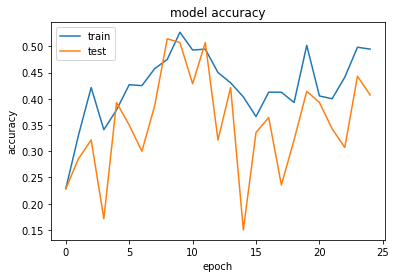

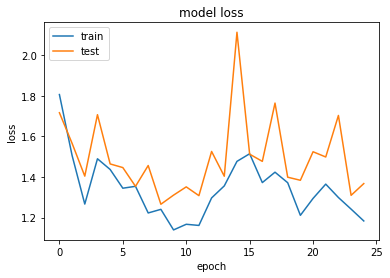

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(V1, y, test_size = 0.20, random_state = 0)

V1_model = model()

history = V1_model.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_test, y_test))

score = V1_model.evaluate(X_test, y_test)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Deep learning model for ECG LEAD V2

Epoch 1/25
18/18 [==============================] - 47s 668ms/step - loss: 1.8773 - accuracy: 0.1714 - val_loss: 1.7104 - val_accuracy: 0.2857
Epoch 2/25
18/18 [==============================] - 7s 416ms/step - loss: 1.5597 - accuracy: 0.2964 - val_loss: 1.6155 - val_accuracy: 0.2500
Epoch 3/25
18/18 [==============================] - 7s 415ms/step - loss: 1.4327 - accuracy: 0.3429 - val_loss: 1.5895 - val_accuracy: 0.3500
Epoch 4/25
18/18 [==============================] - 7s 411ms/step - loss: 1.5723 - accuracy: 0.3089 - val_loss: 1.6631 - val_accuracy: 0.2643
Epoch 5/25
18/18 [==============================] - 7s 407ms/step - loss: 1.4945 - accuracy: 0.3643 - val_loss: 1.5027 - val_accuracy: 0.3643
Epoch 6/25
18/18 [==============================] - 8s 421ms/step - loss: 1.5221 - accuracy: 0.3375 - val_loss: 1.5824 - val_accuracy: 0.2786
Epoch 7/25
18/18 [==============================] - 7s 415ms/step - loss: 1.4965 - accuracy: 0.3250 - val_loss: 1.5131 - val_accuracy: 0.3143
Epoch

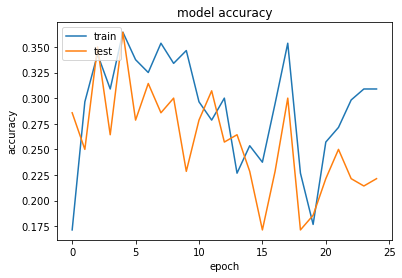

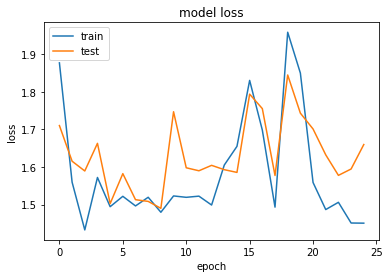

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(V2, y, test_size = 0.20, random_state = 0)

V2_model = model()

history = V2_model.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_test, y_test))

score = V2_model.evaluate(X_test, y_test)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Deep learning model for ECG LEAD V3

Epoch 1/25
18/18 [==============================] - 46s 665ms/step - loss: 1.8162 - accuracy: 0.2196 - val_loss: 1.8078 - val_accuracy: 0.3357
Epoch 2/25
18/18 [==============================] - 8s 432ms/step - loss: 1.5413 - accuracy: 0.2911 - val_loss: 1.5807 - val_accuracy: 0.2286
Epoch 3/25
18/18 [==============================] - 8s 428ms/step - loss: 1.4121 - accuracy: 0.3321 - val_loss: 1.4514 - val_accuracy: 0.4143
Epoch 4/25
18/18 [==============================] - 7s 412ms/step - loss: 1.4807 - accuracy: 0.3357 - val_loss: 1.5485 - val_accuracy: 0.3429
Epoch 5/25
18/18 [==============================] - 7s 405ms/step - loss: 1.4941 - accuracy: 0.2821 - val_loss: 1.5273 - val_accuracy: 0.4143
Epoch 6/25
18/18 [==============================] - 7s 413ms/step - loss: 1.3961 - accuracy: 0.3929 - val_loss: 1.5093 - val_accuracy: 0.2500
Epoch 7/25
18/18 [==============================] - 7s 413ms/step - loss: 1.6971 - accuracy: 0.3196 - val_loss: 1.6634 - val_accuracy: 0.2857
Epoch

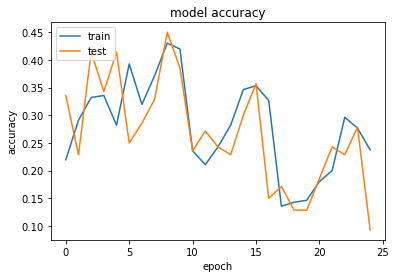

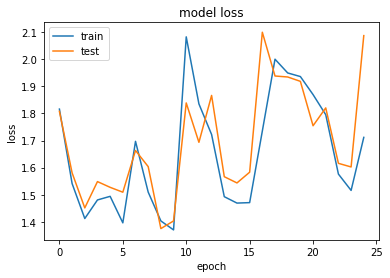

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(V3, y, test_size = 0.20, random_state = 0)

V3_model = model()

history = V3_model.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_test, y_test))

score = V3_model.evaluate(X_test, y_test)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Deep learning model for ECG LEAD V4

Epoch 1/25
18/18 [==============================] - 47s 683ms/step - loss: 1.8757 - accuracy: 0.2214 - val_loss: 1.8545 - val_accuracy: 0.2429
Epoch 2/25
18/18 [==============================] - 7s 414ms/step - loss: 1.7806 - accuracy: 0.2625 - val_loss: 1.6449 - val_accuracy: 0.2786
Epoch 3/25
18/18 [==============================] - 8s 425ms/step - loss: 1.4866 - accuracy: 0.3018 - val_loss: 1.6571 - val_accuracy: 0.2500
Epoch 4/25
18/18 [==============================] - 7s 410ms/step - loss: 1.4835 - accuracy: 0.2964 - val_loss: 1.5144 - val_accuracy: 0.3214
Epoch 5/25
18/18 [==============================] - 8s 422ms/step - loss: 1.5547 - accuracy: 0.3036 - val_loss: 1.6455 - val_accuracy: 0.2214
Epoch 6/25
18/18 [==============================] - 8s 431ms/step - loss: 1.5320 - accuracy: 0.2714 - val_loss: 1.5834 - val_accuracy: 0.2429
Epoch 7/25
18/18 [==============================] - 8s 432ms/step - loss: 1.5619 - accuracy: 0.2375 - val_loss: 1.5473 - val_accuracy: 0.2500
Epoch

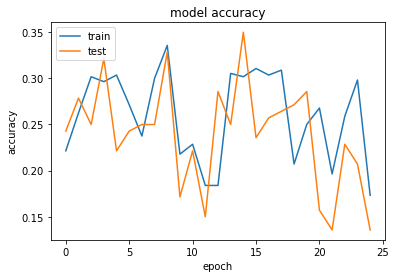

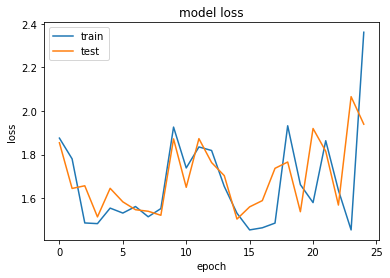

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(V4, y, test_size = 0.20, random_state = 0)

V4_model = model()

history = V4_model.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_test, y_test))

score = V4_model.evaluate(X_test, y_test)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Deep learning model for ECG LEAD V5

Epoch 1/25
18/18 [==============================] - 45s 664ms/step - loss: 1.8710 - accuracy: 0.2321 - val_loss: 1.8415 - val_accuracy: 0.2571
Epoch 2/25
18/18 [==============================] - 8s 427ms/step - loss: 1.5415 - accuracy: 0.3571 - val_loss: 1.5084 - val_accuracy: 0.3071
Epoch 3/25
18/18 [==============================] - 8s 426ms/step - loss: 1.4859 - accuracy: 0.3304 - val_loss: 1.6789 - val_accuracy: 0.2286
Epoch 4/25
18/18 [==============================] - 8s 432ms/step - loss: 1.4532 - accuracy: 0.3786 - val_loss: 1.5161 - val_accuracy: 0.3357
Epoch 5/25
18/18 [==============================] - 8s 428ms/step - loss: 1.5649 - accuracy: 0.3464 - val_loss: 1.5720 - val_accuracy: 0.2643
Epoch 6/25
18/18 [==============================] - 7s 417ms/step - loss: 1.6342 - accuracy: 0.2946 - val_loss: 1.6870 - val_accuracy: 0.2286
Epoch 7/25
18/18 [==============================] - 7s 406ms/step - loss: 1.7371 - accuracy: 0.2357 - val_loss: 1.6776 - val_accuracy: 0.2357
Epoch

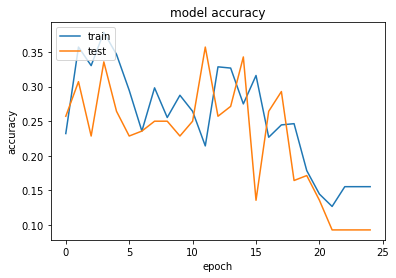

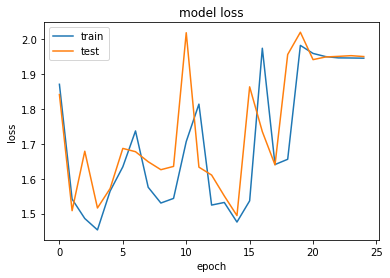

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(V5, y, test_size = 0.20, random_state = 0)

V5_model = model()

history = V5_model.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_test, y_test))

score = V5_model.evaluate(X_test, y_test)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Deep learning model for ECG LEAD V6

Epoch 1/25
18/18 [==============================] - 18s 337ms/step - loss: 1.9537 - accuracy: 0.1536 - val_loss: 1.9430 - val_accuracy: 0.1786
Epoch 2/25
18/18 [==============================] - 5s 270ms/step - loss: 1.8471 - accuracy: 0.2232 - val_loss: 1.8678 - val_accuracy: 0.2000
Epoch 3/25
18/18 [==============================] - 5s 279ms/step - loss: 1.8494 - accuracy: 0.2321 - val_loss: 1.6966 - val_accuracy: 0.2786
Epoch 4/25
18/18 [==============================] - 5s 276ms/step - loss: 1.5387 - accuracy: 0.2750 - val_loss: 1.5799 - val_accuracy: 0.2214
Epoch 5/25
18/18 [==============================] - 5s 282ms/step - loss: 1.5029 - accuracy: 0.3107 - val_loss: 1.6686 - val_accuracy: 0.2643
Epoch 6/25
18/18 [==============================] - 5s 265ms/step - loss: 1.5418 - accuracy: 0.3000 - val_loss: 1.6792 - val_accuracy: 0.2500
Epoch 7/25
18/18 [==============================] - 5s 267ms/step - loss: 1.4842 - accuracy: 0.3089 - val_loss: 1.5900 - val_accuracy: 0.2929
Epoch

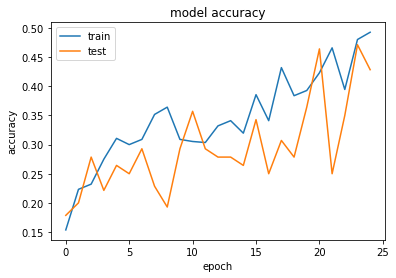

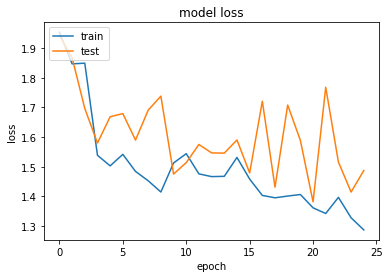

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(V6, y, test_size = 0.20, random_state = 0)

V6_model = model()

history = V6_model.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_test, y_test))

score = V6_model.evaluate(X_test, y_test)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predicted Output

In [ ]:
leaddatas = [I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6]
modelnames = ["lead_I_model","lead_II_model","lead_III_model","aVR_model","aVL_model","aVF_model","V1_model","V2_model","V3_model","V4_model","V5_model","V6_model"]
models = [lead_I_model,lead_II_model,lead_III_model,aVR_model,aVL_model,aVF_model,V1_model,V2_model,V3_model,V4_model,V5_model,V6_model]
for i in range(12):
    leaddate = np.array([leaddatas[i][1]])
    predicted = models[i].predict(leaddate)
    print("\n", modelnames[i], "Predicted:  ", np.argmax(predicted))

1/1 [==============================] - 0s 30ms/step

 lead_I_model Predicted:   5
1/1 [==============================] - 0s 32ms/step

 lead_II_model Predicted:   1
1/1 [==============================] - 0s 32ms/step

 lead_III_model Predicted:   4
1/1 [==============================] - 0s 37ms/step

 aVR_model Predicted:   5
1/1 [==============================] - 0s 36ms/step

 aVL_model Predicted:   5
1/1 [==============================] - 0s 27ms/step

 aVF_model Predicted:   5
1/1 [==============================] - 0s 32ms/step

 V1_model Predicted:   6
1/1 [==============================] - 0s 35ms/step

 V2_model Predicted:   5
1/1 [==============================] - 0s 29ms/step

 V3_model Predicted:   3
1/1 [==============================] - 0s 36ms/step

 V4_model Predicted:   5
1/1 [==============================] - 0s 26ms/step

 V5_model Predicted:   3
1/1 [==============================] - 1s 1s/step

 V6_model Predicted:   6
